## Machine specific data

In [3]:
PSIS_DIRECTORY = '../../assignments'
DATA_PATH = '../../bepipred3.json'

## Imports

In [4]:
import json
import numpy as np
import pystan
import matplotlib.pyplot as plt
from scipy.special import logit, expit
import sys

sys.path.append(PSIS_DIRECTORY)
import psis

## Load data

In [5]:
with open(DATA_PATH) as file:
    data = json.load(file)

In [7]:
print(data[0].keys())

dict_keys(['asa', 'desc', 'disorder', 'epitope', 'id', 'interface', 'method', 'phi', 'preds', 'psi', 'q3', 'q3_prob', 'q8', 'q8_prob', 'rsa', 'seq'])


In [9]:
# Check that all data has the same amino acids, predictions and labels
for protein in data:
    assert len(protein['epitope']) == len(protein['preds']) == len(protein['seq'])

## Model 1:

Epitope status calculated as logistic regression of prediction:

$ep = logit^{-1}(\alpha + \beta * pred)$

In [16]:
with open('models/pooled.stan') as f:
    model_1_code = f.read()

In [21]:
total_aminoacids = 0
for protein in data:
    total_aminoacids += len(protein['epitope'])
    
epitopes = np.empty(total_aminoacids, dtype=np.int32)
scores = np.empty(total_aminoacids, dtype=np.float32)

index = 0
for protein in data:
    length = len(protein['epitope'])
    epitopes[index:index+length] = protein['epitope']
    scores[index:index+length] = protein['preds']
    index += length
    
standata_1 = {'total_aa': total_aminoacids,
        'epitopes': epitopes,
        'scores': scores
       }

In [17]:
model_1 = pystan.StanModel(model_code=model_1_code, model_name='Model_1')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_1_15dac7ff361ffbd44467ef7cae14a597 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp8u6qxa4t/stanfit4Model_1_15dac7ff361ffbd44467ef7cae14a597_8526268102433384056.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
fit_1 = model_1.sampling(data=standata_1)

In [41]:
extract_1.keys()

odict_keys(['params', 'lp__'])

In [23]:
print(fit_1)

Inference for Stan model: Model_1_15dac7ff361ffbd44467ef7cae14a597.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
params[1]  -3.57  1.4e-3   0.04  -3.65   -3.6  -3.57  -3.55   -3.5    887    1.0
params[2]   12.6    0.01   0.37  11.89  12.35   12.6  12.86  13.32    902    1.0
lp__      -1.3e4    0.03   0.95 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1249    1.0

Samples were drawn using NUTS at Mon May  6 14:43:55 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [34]:
# Calculate PSIS LOO
extract_1 = fit_1.extract()
n_obs = len(extract_1['params'])
model_1_loglik = np.empty((n_obs, standata_1['total_aa']), dtype=np.float32)
mask = standata_1['epitopes'] == 1
for i in range(4000):
    a, b = extract_1['params'][i]
    ps = expit(a + b*standata_1['scores'])
    ps[~mask] = 1-ps[~mask]
    model_1_loglik[i] = np.log(ps)

In [35]:
model_1_loo, model_1_loos, model_1_ks = psis.psisloo(model_1_loglik)

In [36]:
print(model_1_loo)

-12992.127


In [49]:
mask = standata_1['epitopes'] == 1
before_neg = standata_1['scores'][~mask]
before_pos = standata_1['scores'][mask]
after_neg = expit(-3.57 + 12.6 * before_neg)
after_pos = expit(-3.57 + 12.6 * before_pos)

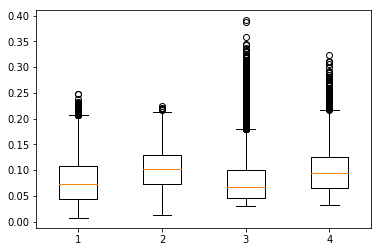

In [51]:
plt.boxplot([before_neg, before_pos, after_neg, after_pos]);

## Model 2

In [15]:
total_aminoacids = 0
for i, protein in enumerate(data):
    if not len(protein['epitope']) == len(protein['preds']):
        continue
    total_aminoacids += len(protein['epitope'])
    
epitopes = np.empty(total_aminoacids, dtype=np.int)
scores = np.empty(total_aminoacids, dtype=np.float)

index = 0
for protein in data:
    if not len(protein['epitope']) == len(protein['preds']):
        continue
    length = len(protein['epitope'])
    epitopes[index:index+length] = protein['epitope']
    scores[index:index+length] = protein['preds']
    
standata = {'total_aa': total_aminoacids,
        'epitopes': epitopes,
        'scores': scores
       }

In [24]:
sm = pystan.StanModel(model_code=stan_code, model_name='Logistic')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Logistic_41992252ca51711f53aac9b1a8217b2f NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp6i_e4i4v/stanfit4Logistic_41992252ca51711f53aac9b1a8217b2f_355907498657462649.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [25]:
fit = sm.sampling(data=standata)
print(fit)

Inference for Stan model: Logistic_41992252ca51711f53aac9b1a8217b2f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
params[1]  -8.01  6.8e-3   0.24  -8.51  -8.17   -8.0  -7.84  -7.56   1273   1.01
params[2]  41.53    0.06   2.07  37.64  40.11  41.48  42.93  45.62   1304   1.01
lp__      -285.8    0.03   1.09 -288.7 -286.2 -285.4 -285.0 -284.8   1050    1.0

Samples were drawn using NUTS at Fri May  3 13:42:48 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [24]:
pooled_loglik = np.empty((4000, standata['total_aa']), dtype=np.float32)
extract = fit.extract()
mask = standata['epitopes'] == 1
for i in range(4000):
    a, b = extract['params'][i]
    ps = expit(a + b*standata['scores'])
    ps[~mask] = 1-ps[~mask]
    pooled_loglik[i] = np.log(ps)

NameError: name 'pooled_loglik' is not defined

### Plot distributions of preds, true and false

In [136]:
true_preds, false_preds = list(), list()
true_corr, false_corr = list(), list()
#for protein in data:
for pred, isepitope in zip(standata['scores'], standata['epitopes']):
    corr = expit(-7.87 + 42.94*pred)
    if corr > 0.8:
        print(pred)
        raise ValueError
    if isepitope < 0.5:
        false_preds.append(pred)
        false_corr.append(corr)
    else:
        true_preds.append(pred)
        true_corr.append(corr)

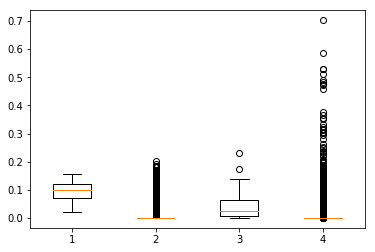

In [137]:
plt.boxplot([true_preds, false_preds, true_corr, false_corr]);

In [6]:
hm = pystan.StanModel(model_code=hierarchical_code, model_name='Logistic')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Logistic_8e181146f08daeb022d7becb3b838a0b NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmps4ilfrpy/stanfit4Logistic_8e181146f08daeb022d7becb3b838a0b_899705431127022765.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [19]:
aa_dict = {x:i+1 for i,x in enumerate('ACDEFGHIKLMNPQRSTVWYX')}
aas = list()
for protein in data:
    if len(protein['seq']) != len(protein['epitope']):
        print(1)
        continue
    for aa in protein['seq']:
        aas.append(aa_dict[aa])
        
aas = np.array(aas, dtype=np.int)

print(len(np.unique(aas)))
standata = {'total_aa': total_aminoacids,
        'epitopes': epitopes,
        'scores': scores,
            'aa':aas,
        'classes': len(np.unique(aas))
       }

21


In [20]:
fit2 = hm.sampling(data=standata)
print(fit2)

Inference for Stan model: Logistic_8e181146f08daeb022d7becb3b838a0b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_mu     -8.07    0.03   0.29  -8.67  -8.26  -8.06  -7.88  -7.55    100   1.02
beta_sigma   0.38    0.02   0.21   0.08   0.22   0.35   0.51   0.89    110   1.02
alpha        41.3    0.14   2.09  37.62  39.76  41.19   42.7  45.56    225   1.01
beta[1]     -8.18    0.03   0.42  -9.08  -8.44  -8.15  -7.89  -7.47    161   1.01
beta[2]     -8.05    0.03   0.47  -9.05  -8.33  -8.05  -7.74  -7.17    266   1.01
beta[3]     -8.18    0.03   0.46  -9.24  -8.46  -8.15  -7.85  -7.46    283   1.01
beta[4]     -7.96    0.02    0.4  -8.79   -8.2  -7.94   -7.7  -7.21    375   1.01
beta[5]     -8.16    0.03   0.43  -9.08  -8.44  -8.13  -7.87  -7.41    170   1.02
beta[6]     -7.95    0.02   0.37  -8.73  -8.19  -7.94   -7.7  -7.26    254 

In [26]:
pooled_loglik.sum(axis=1).mean(), h_loglik.sum(axis=1).mean(), 

NameError: name 'pooled_loglik' is not defined

In [27]:
pooled_loglik = np.empty((4000, standata['total_aa']), dtype=np.float32)
extract = fit.extract()
mask = standata['epitopes'] == 1
for i in range(4000):
    a, b = extract['params'][i]
    ps = expit(a + b*standata['scores'])
    ps[~mask] = 1-ps[~mask]
    pooled_loglik[i] = np.log(ps)

In [28]:
pooled_loo, pooled_loos, pooled_ks = psis.psisloo(pooled_loglik)

In [29]:
print(pooled_loo)

-286.7386


In [21]:
h_loglik = np.empty((4000, standata['total_aa']), dtype=np.float32)
extract = fit2.extract()
mask = standata['epitopes'] == 1
for i in range(4000):
    a = extract['alpha'][i]
    b = extract['beta'][i][standata['aa'] - 1]
    ps = expit(b + a*standata['scores'])
    ps[~mask] = 1-ps[~mask]
    if np.any(ps == 0):
        raise ValueError
    h_loglik[i] = np.log(ps)

In [22]:
h_loo, h_loos, h_ks = psis.psisloo(h_loglik)

##### print(h_loo)

In [112]:
def calc_peff(loglik, loo):
    likelihood = np.exp(loglik)
    observationwise_mean = likelihood.mean(axis=0)
    lppd = np.log(observationwise_mean).sum()
    return lppd - loo

In [113]:
calc_peff(pooled_loglik, pooled_loo), calc_peff(h_loglik, h_loo)

(1.5838013, 7.022003)

In [92]:
extract = fit2.extract()
extract['beta'][i][standata['aa'] - 1]

array([-8.81037531, -8.29491075, -8.16511506, ..., -8.20625734,
       -8.00648846, -8.39737347])

In [79]:
standata['aa'].max()

21

In [75]:
extract = fit2.extract()

In [76]:
extract.keys()

odict_keys(['beta_mu', 'beta_sigma', 'alpha', 'beta', 'lp__'])

In [82]:
extract['beta'].shape

(4000, 21)

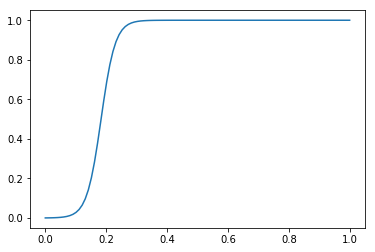

In [121]:
xs = np.linspace(0, 1, 100)
ys = expit(-7.87 + 42.94*xs)
plt.plot(xs, ys)

In [ ]:
for i in 

In [122]:
ps

array([0.99974536, 0.99955155, 0.99955443, ..., 0.99972713, 0.99966682,
       0.99977459])

In [123]:
mask

array([False, False, False, ..., False, False, False])

In [145]:
expit(-7.87 + 42.94*standata['scores'].min())

0.0003818884676828639

In [142]:
standata['scores'][mask].max()

0.15529731

In [143]:
standata['scores'][~mask].max()

0.20328818

In [146]:
from random import randint

In [158]:
n_sims = 100000
fewer = 0
for i in range(n_sims):
    females = np.random.randint(2, size=39).sum()
    if females <= 15:
        fewer += 1
print(fewer/n_sims)

0.0994


In [159]:
from scipy.special import binom

In [163]:
from scipy import stats

In [166]:
stats.binom.cdf(15, 39, 0.5)

0.09979543345980334